# Comparative plots over time

Visualizing obtained data from experiments or simulations is a fundamental step in interpreting and understanding the results. Espacially in engineering, comparative studies are very important. 

In the following, a work flow is proposed for visualizing spatially-resolved data in a comparative study. The workflow uses raw simulation data extracted from ParaView's csv-writer. Each csv-file contains the temporal evolution of numerous variables at a specific point. Moreover, the spatial coordinates to the point in space are also in the data set.

For educational purposes, the simulations are carried out multiple times with different boundary conditions. To this end, the file names read:

![title](img/input-files-terminal.png)

Herein, the file "point-C-pressure-2.csv" contains the data obtained at point "C" for the boundary conditions corresponding to the second run. 

## Setup

In [1]:
%matplotlib inline
import os
import glob
import sys
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import constants

A custom plot style is loaded through a style-sheet, which is based on the seaborn libary.

In [2]:
# set custom matplotlib rc file 
url_rcfile = 'https://raw.githubusercontent.com/TheFerry10/ml-parameter-identification/master/seaborn-custom-style.mplstyle'
mpl.style.use(url_rcfile)

# Uncomment the following lines, if you wish to use latex fonts in matplotlib
# figures. The first line installs latex fonts, while the second line activates
# the fonts in the matplotlib rc file

#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
mpl.rcParams['text.usetex'] = True

Besides this, a few helper functions are imported, which are defined outside the Jupyter notebook. 

In [3]:
from plotstandards import *
from plotlabels import Labels

In [4]:
def convert_centimeters_to_inches(length_in_centimeters):
    return length_in_centimeters * constants.centi / constants.inch

In [5]:
TEXTWIDTH_IN_CENTIMETERS = 16
plotStyle = CustomPlotStyle(textwidth_in_inches=convert_centimeters_to_inches(TEXTWIDTH_IN_CENTIMETERS))
plotLabels = Labels()

Set input and output directory

In [6]:
INPUT_DIR = 'input-data'
OUTPUT_DIR = 'output-data'

PATH_TO_FIGURES =  os.path.join(OUTPUT_DIR, 'fig/')
if not os.path.isdir(PATH_TO_FIGURES):
    os.mkdir(PATH_TO_FIGURES)

## Input data

All input file names are collected in a list by making use of the `glob` module. The wildcards are chosen such that it matches all file names of the csv-files. 

In [7]:
input_file_names = 'point-[A-Z]-run-[0-9]*.csv'
file_paths = sorted(glob.glob(os.path.join(INPUT_DIR, input_file_names)))

Each csv file contains information at a specific spatial position defined through the Cartesian coordinates $X,Y,Z$. For illustration purposes, a data set is shown in the following: 

In [8]:
print(file_paths[0])
pd.read_csv(file_paths[0]).head()

input-data/point-A-run-0.csv


,Time,KS (id=0 block=1),MULR (id=0 block=1),PHI (id=0 block=1),PVI (id=0 block=1),Point Coordinates_Magnitude (id=0 block=1),Point Coordinates_X (id=0 block=1),Point Coordinates_Y (id=0 block=1),Point Coordinates_Z (id=0 block=1),QL1 (id=0 block=1),...,WL2 (id=0 block=1),n_A_irr (id=0 block=1),n_A_rev (id=0 block=1),p (id=0 block=1),qm (id=0 block=1),rhoFs (id=0 block=1),s_G (id=0 block=1),u_x (id=0 block=1),u_y (id=0 block=1),vtkValidPointMask (id=0 block=1)
0,0,1.964960e-12,0.001,0.195,0.019367,0.707107,0.5,0.5,0,3.100070e-08,...,-4.658480e-07,4.916910e-16,2.511350e-16,63.5319,269.304,0,9.964050e-13,6.099280e-07,-0.000001,1
1,1,1.964960e-12,0.001,0.195,0.068948,0.707107,0.5,0.5,0,1.461870e-07,...,-2.090970e-06,1.752740e-15,2.980330e-15,301.4850,269.425,0,9.763790e-13,2.423480e-06,-0.000006,1
2,2,1.964960e-12,0.001,0.195,0.118529,0.707107,0.5,0.5,0,2.623610e-07,...,-3.738240e-06,2.975640e-15,6.849100e-15,549.2430,269.525,0,9.506170e-13,4.236250e-06,-0.000010,1
3,3,1.964960e-12,0.001,0.195,0.168110,0.707107,0.5,0.5,0,3.784490e-07,...,-5.387810e-06,4.157630e-15,1.133730e-14,798.8220,269.607,0,9.218180e-13,6.046980e-06,-0.000015,1
4,4,1.964960e-12,0.001,0.195,0.217690,0.707107,0.5,0.5,0,4.944960e-07,...,-7.037640e-06,5.298030e-15,1.609530e-14,1048.7400,269.675,0,8.917910e-13,7.857170e-06,-0.000019,1


### Preprocessing 

The data set in this example contains multiple columns, while only a few variables will be used in the following. For an organized treatment of the data, the csv-files are imported in an object-oriented design. The following manipulations need to be performed on each imported data set:
- reading the data
- extracting the specified spatial position (point) from the file name
- extracting the boundary condition identifier from the file name
- setting a combined index from point and bc index
- cleaning column names

In [9]:
class DataAtPoint(object):
    """
    This class manages data frames, which are loaded from 
    csv-files. Information from the file names can be
    extracted, while this information can be assigned as 
    a MultiIndex to the data frame.
    """
    def __init__(self, file_path):
        self.file_name = os.path.basename(file_path)
        self.read_from_file()       
        
    def read_from_file(self):
        self.df = pd.read_csv(file_path)
        
    def get_info_from_file_name(self, reg_expression):
        identifier = re.compile(reg_expression)
        matches = identifier.findall(self.file_name)
        return matches[0]
    
    def collect_info_from_file_name(self, identifiers_in_file_name, seperator='-'):
        self.info_from_file_name = dict([data_at_point.get_info_from_file_name(identifier).split(seperator) for identifier in identifiers_in_file_name])  
            
    def set_index_from_file_name(self):
        index_values_for_row = tuple(self.info_from_file_name.values())
        index_names = tuple(self.info_from_file_name.keys())
        rows_of_data_frame = data_at_point.df.shape[0]
        index_values_for_data_frame = [index_values_for_row]*rows_of_data_frame
        index = pd.MultiIndex.from_tuples(tuples=index_values_for_data_frame,names=index_names)
        self.df.set_index(index,inplace=True)
        
    def clean_col_names(self, del_string):
        del_string_identifier = re.compile(del_string)
        for col_name in self.df.columns:
            new_col_name = del_string_identifier.sub(repl='',string=col_name)
            self.df.rename(columns={col_name: new_col_name}, inplace=True)             

Regular expressions have been used to identiy the point and simulation index from the file name. In a next step, a MultiIndex is assigned to the data frame. Note that for the example data set, the column names contain expressions in paranthesis, e.g. `(id=0 block=1)`. Note in passing, that these expressions were generated through the data extraction process in ParaView. Here, we want to get rid of the expressions in the column names. To this end, the `clean_col_names`-function deletes the specified string `del_string` in all column names. Note that `del_string` could also be expressed through regular expressions, which is very useful in many cases.

All data sets are concatinated into a large data set, which contains all information. The result is saved to a new csv-file. In the following, the complete data set will be used for further investigations. 

In [10]:
del_string_identifier = '\s\(id=\d\sblock=\d\)'
point_identifier = 'point-[A-Z]'
run_identifier = 'run-[0-9]'
identifiers_in_file_name = [point_identifier,run_identifier]


complete_df = pd.DataFrame()
for file_path in file_paths:
    data_at_point = DataAtPoint(file_path)
    data_at_point.collect_info_from_file_name(identifiers_in_file_name,seperator='-')
    data_at_point.set_index_from_file_name()
    data_at_point.clean_col_names(del_string_identifier)
    complete_df = pd.concat([complete_df, data_at_point.df])

In [11]:
file_name_complete_dataset = os.path.join(INPUT_DIR, 'complete_dataset.csv')
complete_df.to_csv(file_name_complete_dataset)

Prior to visualizing results, the points are plotted on the simulation domain. The coordinates of the points have been directly extracted from the data frames.  

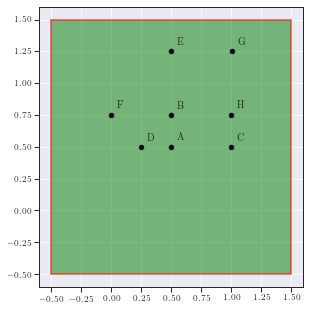

In [12]:
points = complete_df.index.unique(level='point')
run_indices = complete_df.index.unique(level='run')

fig, ax = plotStyle.create_figure(width_scale=0.7, aspect_ratio=1.0)
rect = mpl.patches.Rectangle((-0.5,-0.5),2,2,linewidth=2,edgecolor='r',facecolor='g',alpha=0.5)
ax.add_patch(rect)
for point in points:
    x_coord = complete_df.loc[point]['Point Coordinates_X'].unique()
    y_coord = complete_df.loc[point]['Point Coordinates_Y'].unique()
    ax.plot(x_coord,y_coord,'ko')
    ax.text(x_coord+0.05,y_coord+0.05,point)
    
save_fig('plot-points-on-domain',PATH_TO_FIGURES)

### Data manipulation 

A class is created for convenience to extract specific columns from the previously extracted data frame. 

In [13]:
class Dataset(object):
    def __init__(self,df):
        self.df = df
        self.mask = np.ones((df.shape[0],1), dtype=bool)
        self.run = 0
        self.point = 'A'
        
    def get_data_frame(self):
        return self.df[self.mask].loc[self.point,self.run]
        
    def get_time_in_hours(self):
        return (self.get_data_frame()['TIME'] - 5e3) / constants.hour

    def get_saturation(self):
        return self.get_data_frame()['s_G'] / 1e-3

    def get_viscosity(self):
        return self.get_data_frame()['MULR'] / 1e-3

    def get_velocity(self):
        return self.get_data_frame()['QLABS'] 

In [14]:
def get_label(pressure_index):
    return str(50*(int(pressure_index)+1)) + '$\mathrm{kPa}$'

Load the complete and preprocessed data frame:

In [15]:
complete_df = pd.read_csv(file_name_complete_dataset,index_col=['point','run'])

The following points and boundary conditions can be extracted from the data frame:

In [16]:
points = complete_df.index.unique(level='point')
run_indices = complete_df.index.unique(level='run')

print("Points:", points.values)
print("Boundary condition indentifiers:", run_indices.values)

Points: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H']
Boundary condition indentifiers: [0 1 2 3]


In the following, the results are invesigated for times large than 5e3s and smaller than 3e4s. To this end, the following mask is defined and will be later applied to the data set. 

In [17]:
mask_initial = complete_df['TIME'] >= 5e3
mask_end = complete_df['TIME'] <= 30e3
mask = mask_initial & mask_end

In [18]:
dataset = Dataset(complete_df)
dataset.mask = mask

## Plot selection over time
Through the `Dataset` object it is now very convenient to access the time-dependent data. By specifying the attributes `point` and `run`, the extracted variables (columns) can be plotted over time, which is demonstrated in the following. In both figures, the spatial position is fixed, while each curve corresponds to a different boundary condition (here the boundary conditions are different injection pressures).

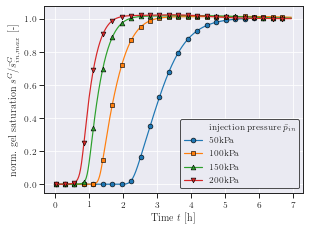

In [19]:
dataset.point = 'A'
legend_description = r'injection pressure $\bar{p}_{in}$'
markers = plotStyle.get_marker_cycle()

fig, ax = plotStyle.create_figure(width_scale=0.7)
create_label_without_line(legend_description, ax)
for run_index in run_indices:
    dataset.run = run_index
    x = dataset.get_time_in_hours()
    y = dataset.get_saturation()
    ax.plot(x,y, marker=next(markers), markevery=20, label=get_label(run_index))

ax.set_xlabel(plotLabels.timeInHours);
ax.set_ylabel(plotLabels.gelSaturationAtPoint);
ax.legend();

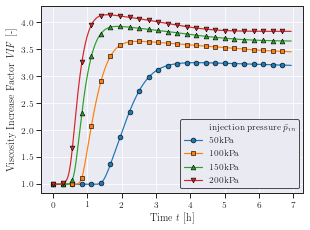

In [20]:
dataset.point = 'B'
legend_description = r'injection pressure $\bar{p}_{in}$'
markers = plotStyle.get_marker_cycle()

fig, ax = plotStyle.create_figure(width_scale=0.7)
create_label_without_line(legend_description,ax)
for run_index in run_indices:
    dataset.run = run_index
    x = dataset.get_time_in_hours()
    y = dataset.get_viscosity()
    ax.plot(x,y, marker=next(markers), markevery=20, label=get_label(run_index))

ax.set_xlabel(plotLabels.timeInHours);
ax.set_ylabel(plotLabels.viscosityIncreaseFactor);
ax.legend();

Finally, the time-dependent evolution of two variables in combination with different spatial positions (here points A and B) can also be illustrated within a single figure. Note that the proposed framework is very flexible with regard to the number of variables or points.  

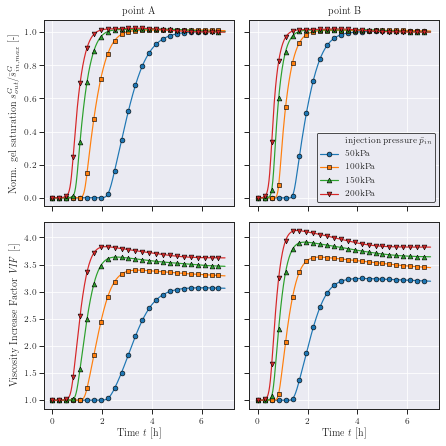

In [21]:
legend_description = r'injection pressure $\bar{p}_{in}$'
points = ['A','B']
num_points = len(points)

fig, (ax_saturation, ax_viscosity) = plt.subplots(nrows=2,ncols=num_points,figsize=set_figsize(aspect_ratio=1), sharex='col', sharey='row')
ax_legend = ax_saturation[len(points)-1]
create_label_without_line(legend_description, ax_legend)

for (point,point_index) in zip(points,range(num_points)):
    dataset.point = point
    markers_saturation = plotStyle.get_marker_cycle()
    markers_viscosity = plotStyle.get_marker_cycle()
    colors_saturation = plotStyle.get_color_cycle()
    colors_viscosity = plotStyle.get_color_cycle()    
    
    for run_index in run_indices:            
        dataset.run = run_index
        t = dataset.get_time_in_hours()
        s = dataset.get_saturation()
        mu = dataset.get_viscosity()
        ax_saturation[point_index].plot(t,s, marker=next(markers_saturation), markevery=20, label=get_label(run_index))
        ax_viscosity[point_index].plot(t,mu, marker=next(markers_viscosity), markevery=20)
                
for point_index in range(num_points):
    ax_saturation[point_index].title.set_text('point {}'.format(points[point_index]))
    ax_viscosity[point_index].set_xlabel(plotLabels.timeInHours);

ax_saturation[0].set_ylabel(plotLabels.gelSaturation);
ax_viscosity[0].set_ylabel(plotLabels.viscosityIncreaseFactor);
ax_legend.legend();

save_fig('plot-selection-over-time-point-' + '-'.join(points), PATH_TO_FIGURES)